In [8]:
# some standard python imports #
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import MAS_library as MASL
import smoothing_library as SL
import math


In [9]:
def inttopair(n, num_columns):
    row = n // num_columns
    col = n % num_columns
    return row, col

In [68]:
def magsorter(df, low, high, col, delta_g, delta):
    para=df[col]
    condition = (df[col] >= low) & (df[col] < high)
    rows=df[condition].index
    newdf= df.loc[rows]
    newpos = newdf.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    newmag=newdf.loc[:,['K_Mag']].to_numpy(dtype=np.float32)
    
    new_delta_g=[]
    new_delta=[]
    for i in newpos:
        x=int(round(i[0]))
        y=int(round(i[1]))
        z=int(round(i[2]))
        
        tempdelg=delta_g[x][y][z]
        tempdel=delta[x][y][z]
        
        new_delta_g.append(tempdelg)
        new_delta.append(tempdel)

        
    tempb = (np.array(new_delta_g)/np.array(new_delta)).flatten()
    return tempb, newmag

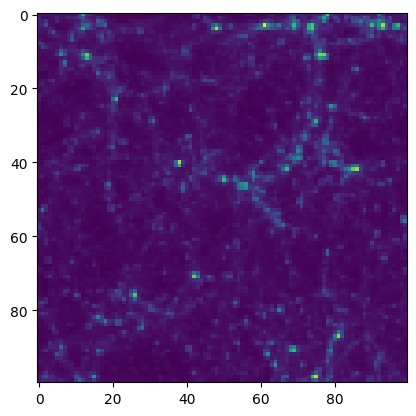

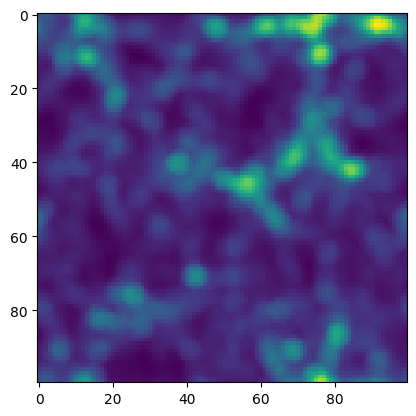

              id  desc_id        pid          Mvir      Rvir       rs  \
0      115038658       -1         -1  3.778000e+14  1468.342  173.826   
1      115117999       -1         -1  2.484000e+14  1276.745  308.091   
2      115038666       -1  115038658  1.495000e+14  1078.016  173.103   
3      115039716       -1         -1  1.300000e+14  1028.897  199.351   
4      115039166       -1         -1  9.669000e+13   932.276  230.178   
...          ...      ...        ...           ...       ...      ...   
46750  115324977       -1  115325023  1.957000e+10    54.733    1.357   
46751  115325270       -1  115325272  1.957000e+10    54.733    2.536   
46752  115327418       -1  115327419  1.957000e+10    54.733    1.149   
46753  115329082       -1  115329081  1.957000e+10    54.733    1.470   
46754  115329477       -1  115329476  1.957000e+10    54.733    3.619   

          vmax         x          y         z  ...       vz     Spin  \
0      1273.96  30.39950   46.35684  43.28916  ... 

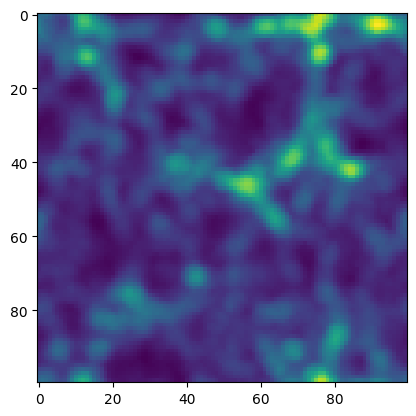

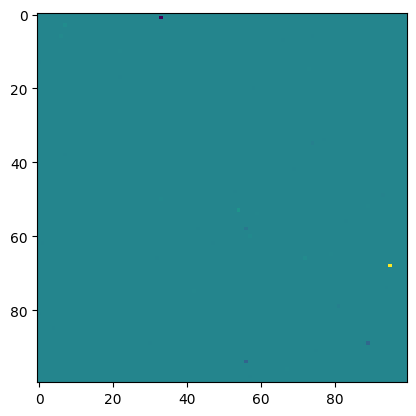

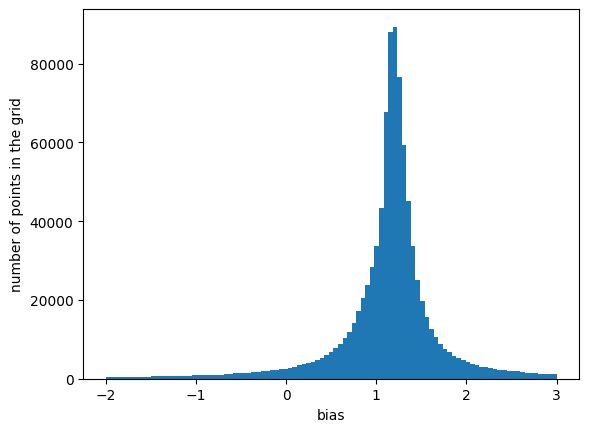

In [14]:

##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 100                         #this is how you specify the size of your density grid (I just made it 100x100)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

#Quick Check
plt.imshow(np.mean(delta,axis=0)) #plot the density field
plt.show()

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_smoothed,axis=0)) 
plt.show()


#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)
print(galaxycat)

pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

#Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0



# smooth the field
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_g_smoothed,axis=0))
plt.show()

b = (delta_g_smoothed/delta_smoothed).flatten()

hist = plt.hist(b, bins = np.linspace(-2,3,100))
plt.xlabel('bias')
plt.ylabel('number of points in the grid')
plt.show()

In [47]:
#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)

In [71]:
##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 116                         #this is how you specify the size of your density grid (I just made it 100x100) (116 to collect all galaxies)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)


pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

#Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0



# smooth the field
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)




# building luminosity bins
k_mag=galaxycat['K_Mag']

k_mean=k_mag.mean()
k_std=k_mag.std()

k_min=math.floor(k_mag.min())
k_max=math.ceil(k_mag.max())

# bin via half mag
size=(k_max-k_min)*2
col='K_Mag'
low=k_min
high=k_min+.5


b_list=[]
label_list=[]
mag_list=[]
for i in range(size):
    templabel=str(low)+" - "+str(high)
    tempb,tempmag=magsorter(galaxycat, low, high, col, delta_g_smoothed, delta_smoothed)
    b_list.append(tempb)
    label_list.append(templabel)
    mag_list.append(tempmag)
    low+=.5
    high+=.5


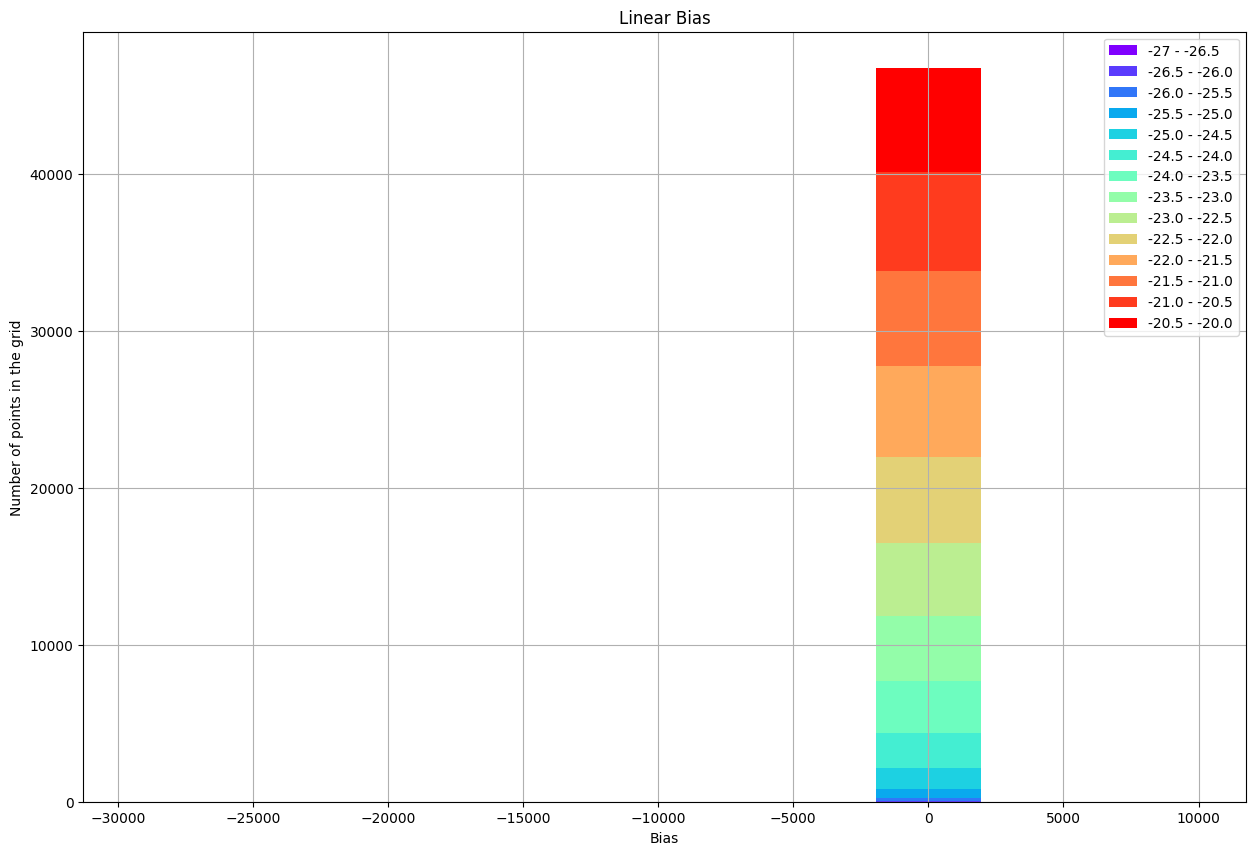

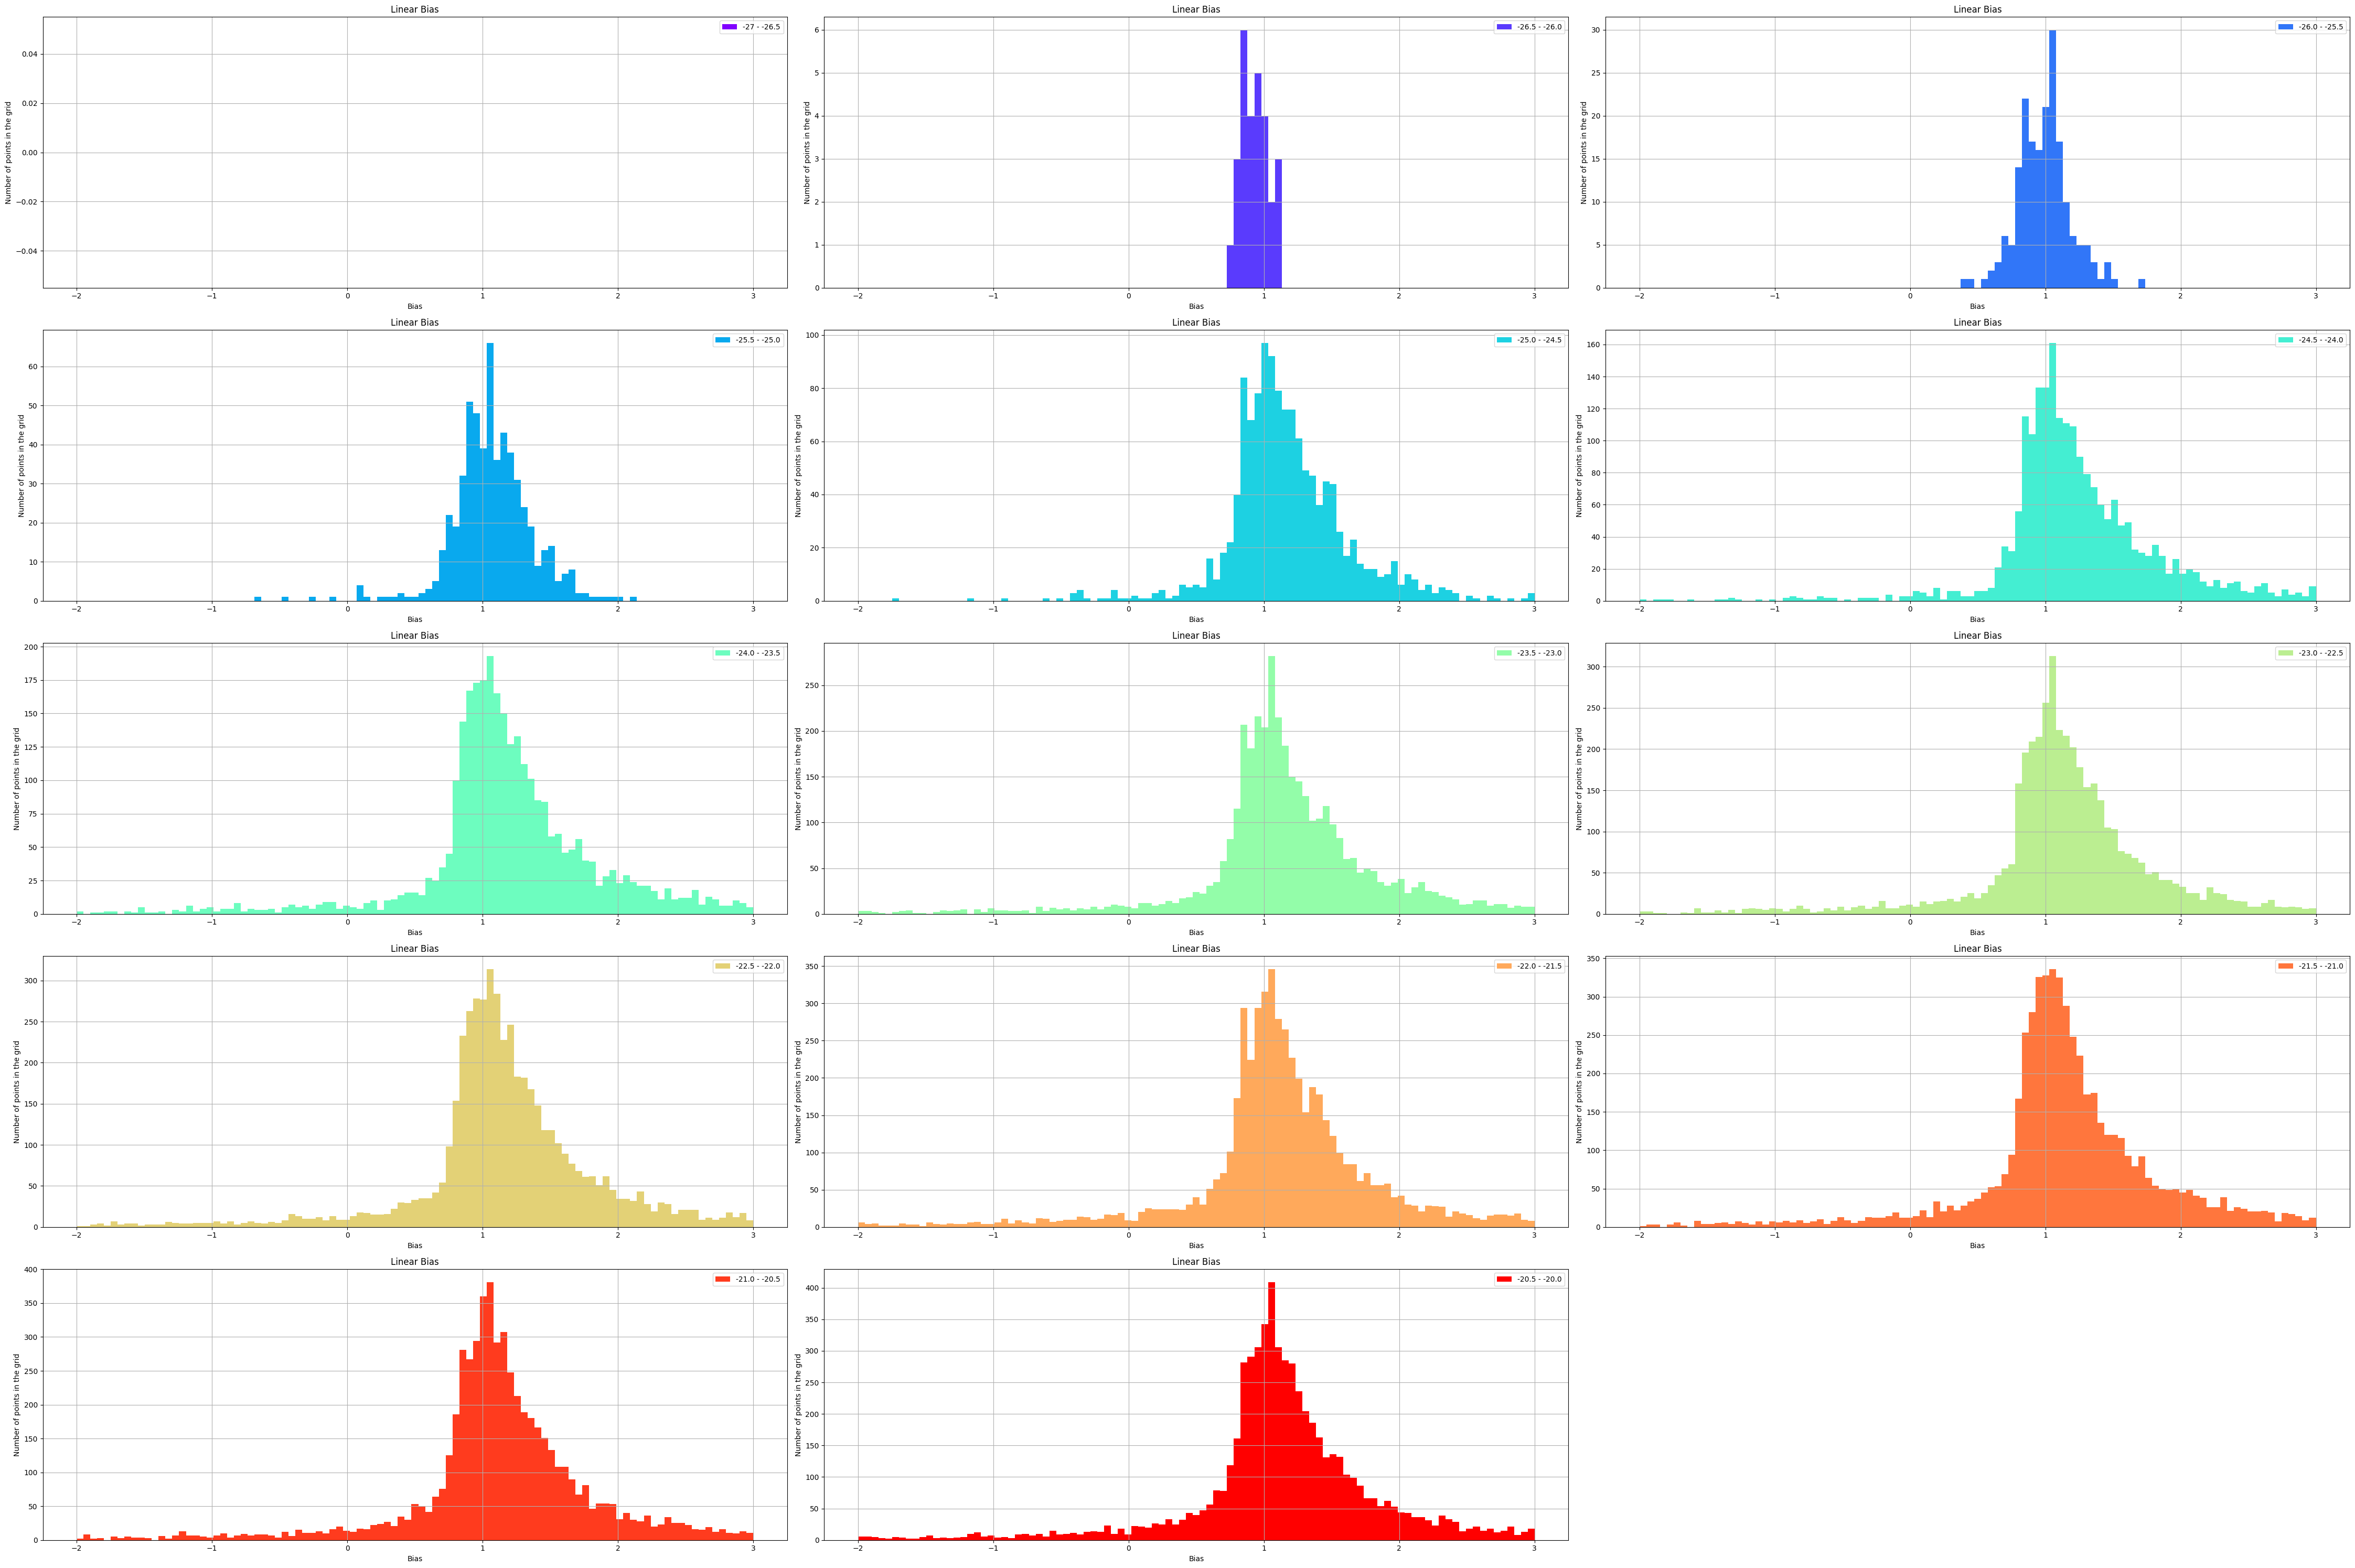

In [75]:
#label_list=[r"$<-2\sigma$",r"$-2\sigma{} - -1\sigma$",r"$-1\sigma{} - \mu$",r"$\mu{} - 1\sigma$",r"$1\sigma{} - 2\sigma$",r"$>2\sigma$"]

color_list = cm.rainbow(np.linspace(0, 1, size))


plt.figure(figsize=(15,10))
hist = plt.hist(b_list,bins = np.linspace(-2,3,100),label=label_list,stacked=True,density=False,color=color_list)
plt.legend()
plt.title('Linear Bias')
plt.xlabel('Bias')
plt.ylabel('Number of points in the grid')
plt.grid()
#plt.savefig("Bias_MagStack.png",format="png")
plt.show()

height=math.ceil(size/3)
fig =plt.figure(figsize=(45,30))
for i in range(len(b_list)):
    q,r=inttopair(i,3)
    ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
    
    hist = ax.hist(b_list[i], bins = np.linspace(-2,3,100),label=label_list[i],color=color_list[i])
    ax.legend()
    ax.title.set_text('Linear Bias')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Number of points in the grid')
    ax.grid()

#plt.savefig("Bias_Magind.png",format="png")
plt.tight_layout()
plt.show()

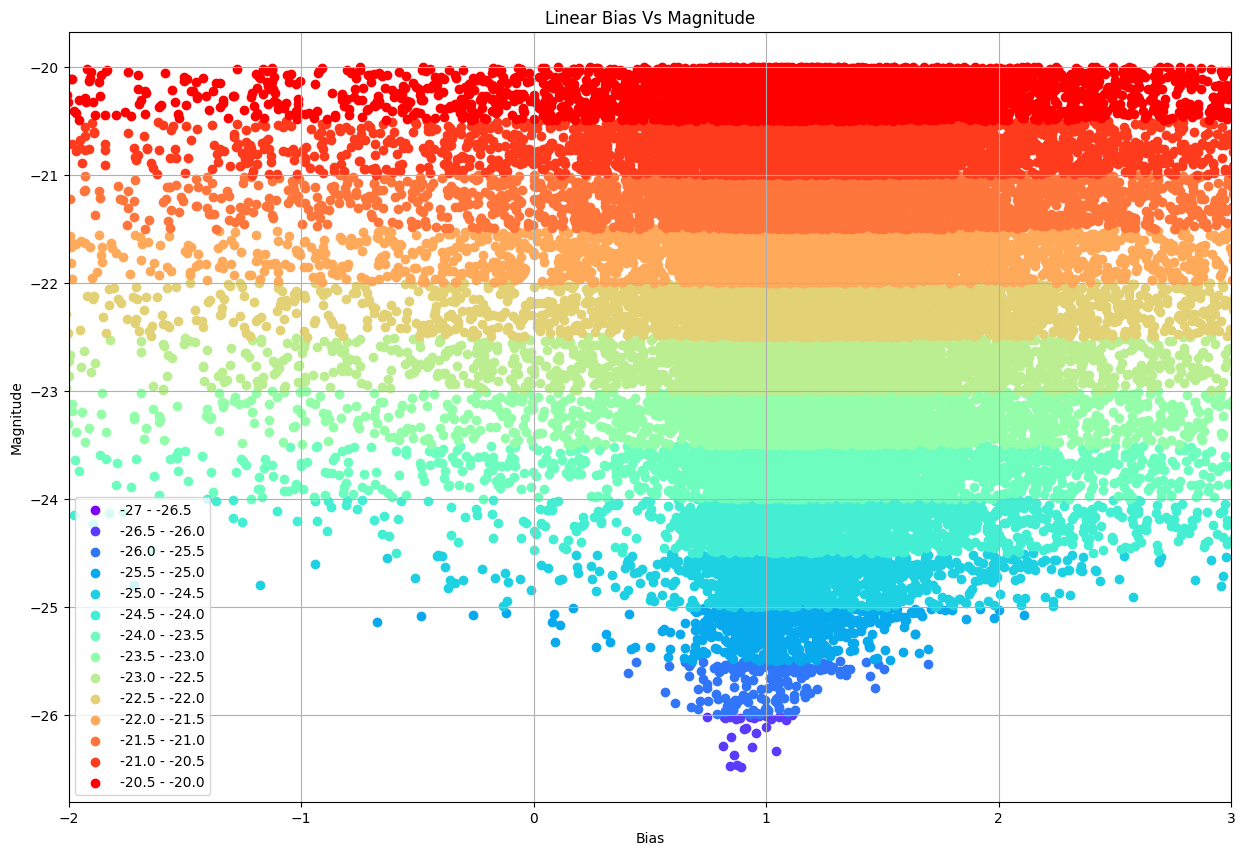

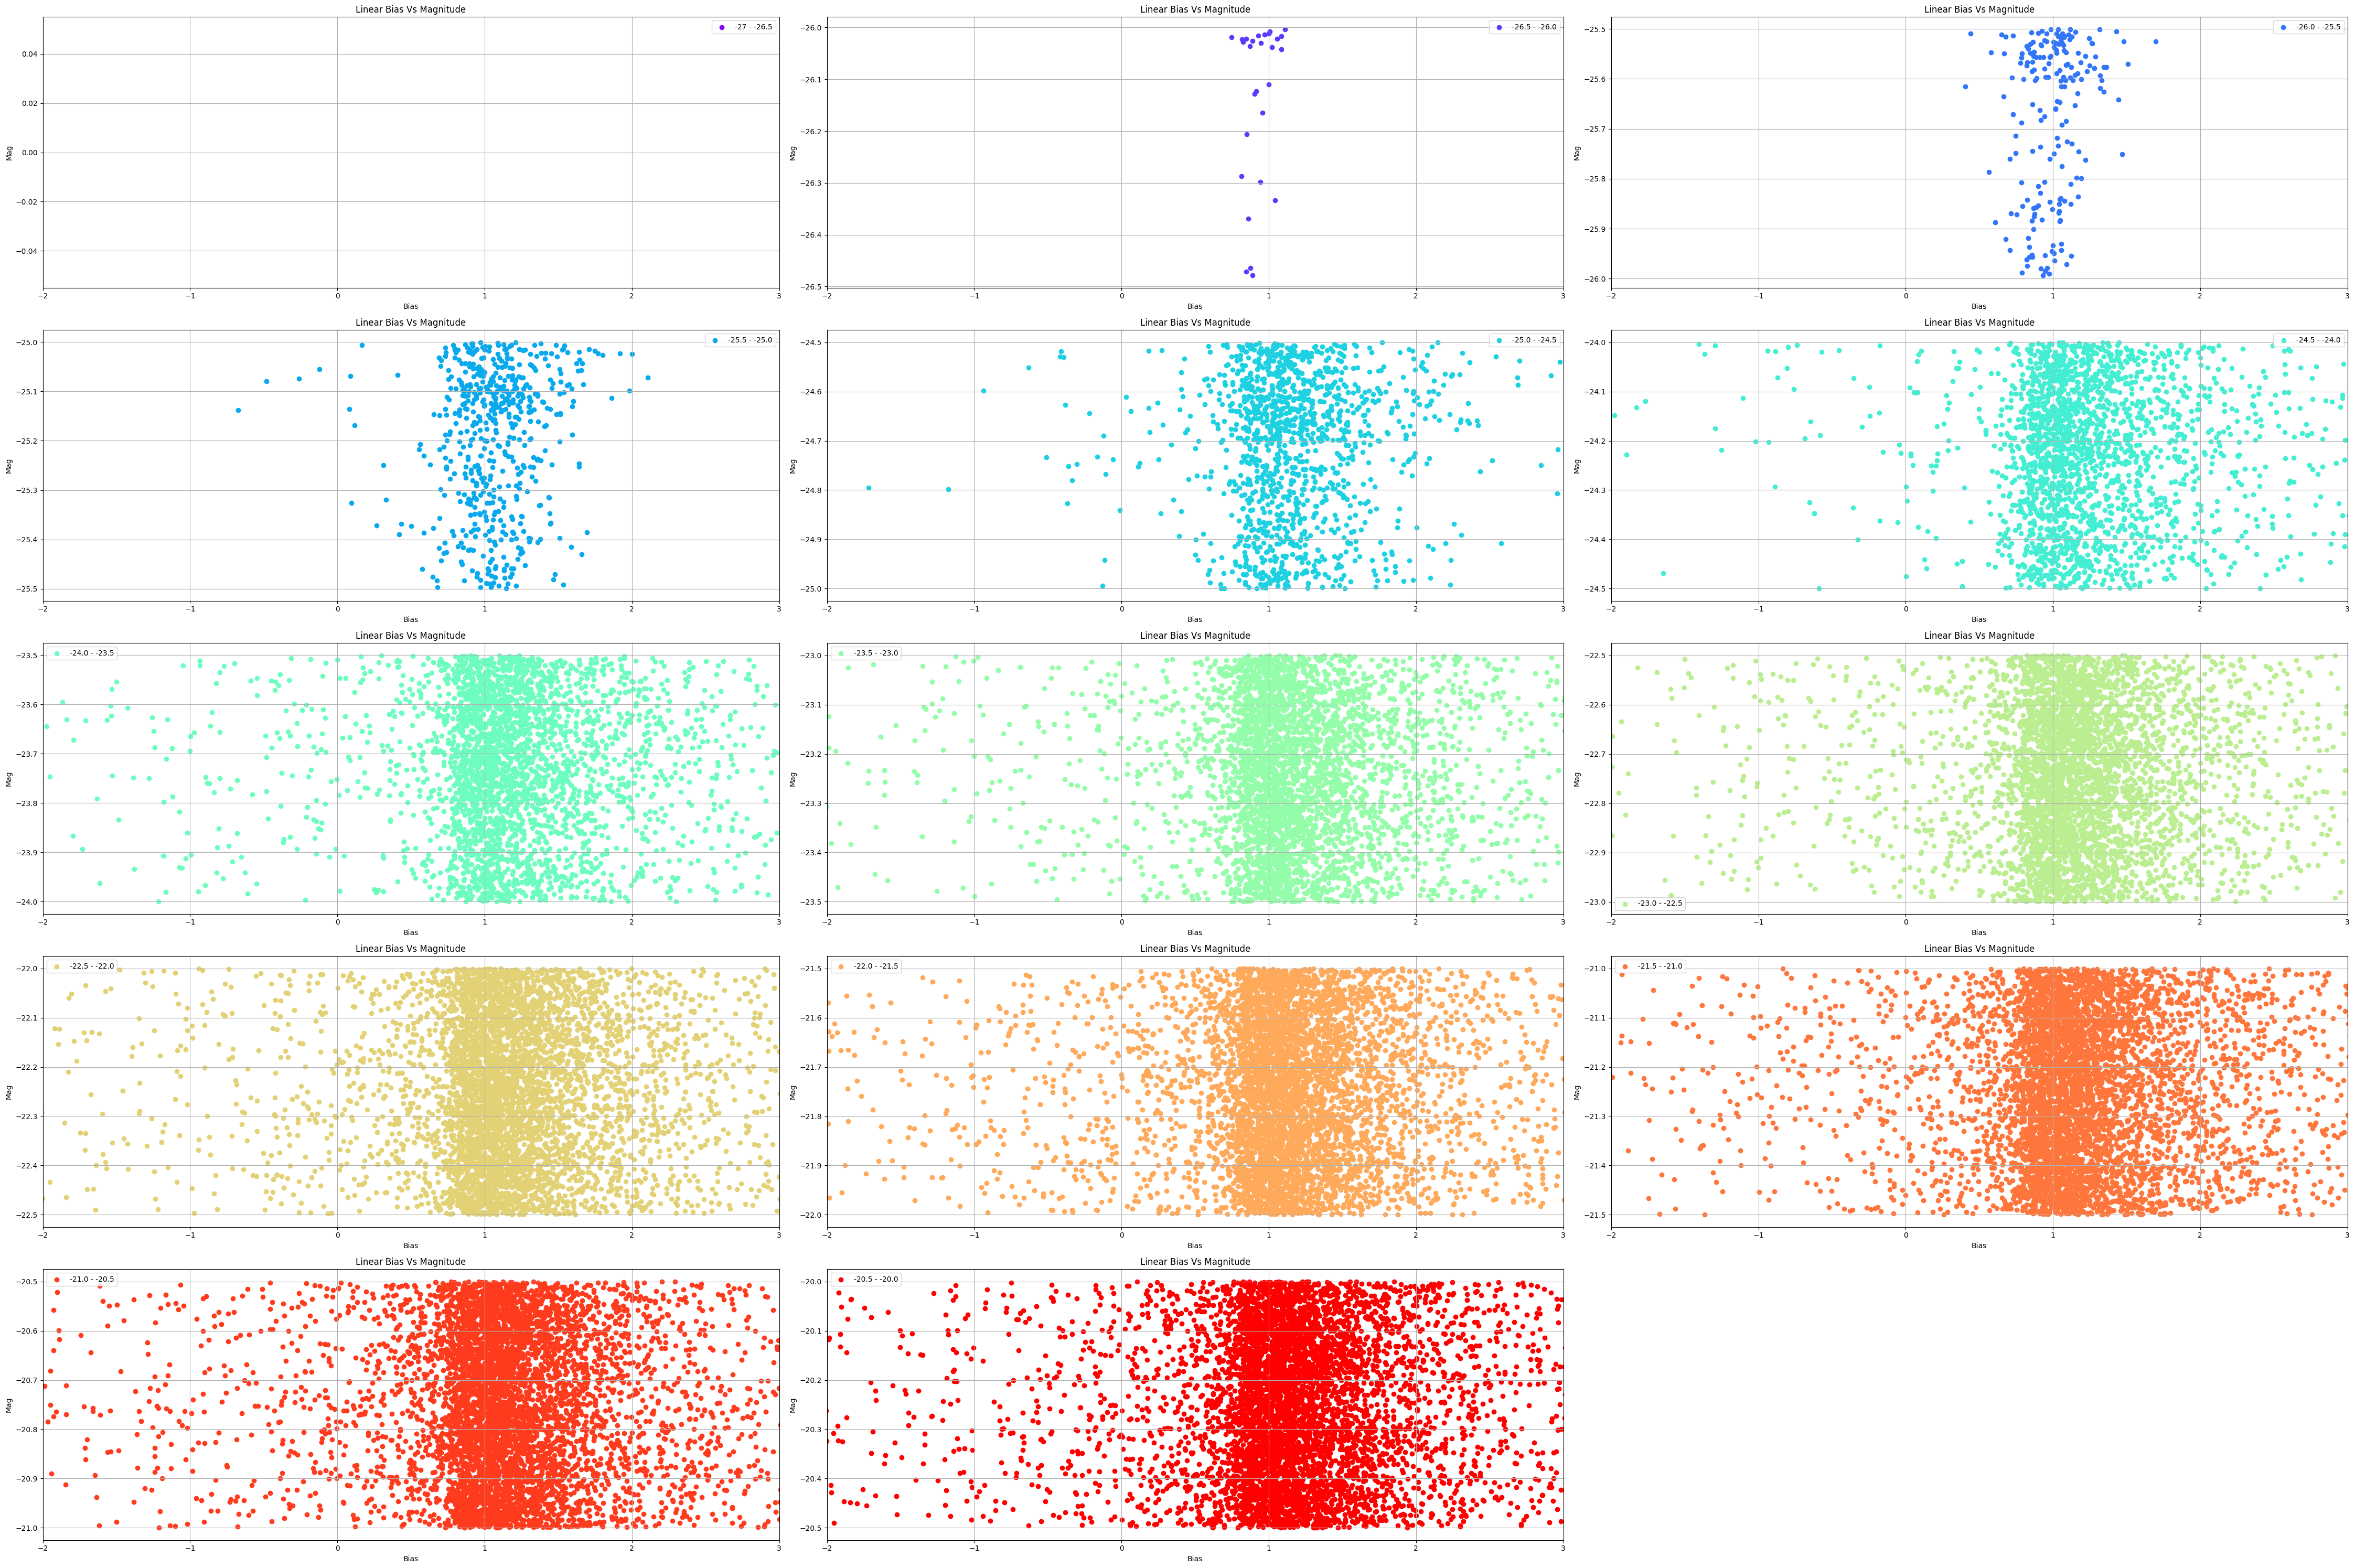

In [78]:
color_list = cm.rainbow(np.linspace(0, 1, size))


plt.figure(figsize=(15,10))
for i in range(len(b_list)):
    plt.scatter(b_list[i],mag_list[i],label=label_list[i],color=color_list[i])
plt.legend()
plt.title('Linear Bias Vs Magnitude')
plt.xlim(-2,3)
plt.xlabel('Bias')
plt.ylabel('Magnitude')
plt.grid()
plt.savefig("BiasVMagcol.png",format="png")
plt.show()

height=math.ceil(size/3)
fig =plt.figure(figsize=(45,30))
for i in range(len(b_list)):
    q,r=inttopair(i,3)
    ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
    
    ax.scatter(b_list[i],mag_list[i],label=label_list[i],color=color_list[i])

    ax.set_xlim(-2,3)
    ax.legend()
    ax.title.set_text('Linear Bias Vs Magnitude')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Mag')
    ax.grid()

plt.savefig("BiasVMagind.png",format="png")
plt.tight_layout()
plt.show()